# Introduction

This notebook and the code contained herein were created by [Aaron Berk](http://asberk.ca), using data kindly provided by Smart Shores in conjunction with the 2017 [BC Data Science Workshop](http://workshop.bcdata.ca). 

## Purpose

The high-level goal of this notebook is to segment the land types observed in a survey of Davis Bay (e.g., river bed from rocks from road from houses). This is one component in a problem of evaluating how shorelines evolve over time as a result of erosion as a function of a land type. Characterizing erosion elucidates environmental impact on an ecosystem and systems level. 


## Data

The survey data used in this notebook is a very large, unstructured sparse point cloud. We have subsampled this data to 10 000 000 points and will work with yet another subsample while demonstrating proof of concept of our method for clustering land types. 

## Methods

We will use mini-batch k-means to cluster the points into texture/land types. The features used in the k-means problem will be constructed as the (z,r,g,b) values of that point and its 10 closest neighbours, where the neighbours are obtained by solving a nearest neighbours problem. For each of these two steps, we will be relying on `scikit-learn`, a commonly used machine learning package in Python. 

In particular, for step 1, we will construct a 10-nearest neighbours tree from the longitude latitude pairs of each point in the subsampled sparse point cloud. This will be performed using `NearestNeighbours`. This tree will determine the 10 nearest neighbours of each point; the (z,r,g,b) data for these points will be concatenated to form a *feature vector* for each point. These feature vectors will be clustered using `MiniBatchKMeans`, from which we will determine cluster membership, hence [in theory] land type. 

# Setting up the workspace

For the purpose of this workshop, I have created several abstractions to make this notebook appear clean. Full code is available on the [GitHub repository for this project](https://github.com/asberk/bcdata-exercises/tree/master/2-second-week/4-smartshores-project). 

## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from DataLoader import DataLoader
from helper_functions import *

## Read in data

The `DataLoader` class is an abstraction which is only partially complete at the moment. It is set up to iterate through batches of the data for bulk processing of the ~57 000 000 points contained in the raw data. For demonstration purposes in this notebook, we will only load one batch, and then subsample that batch. 

In [3]:
POINT_RESOLUTION = 1e-6 # ~10 cm
dl = DataLoader()

Counting total rows...10000000


In [4]:
dl.readData()

Loading group 0...done!


In [5]:
dl.data[0].head()

,lon,lat,z,r,g,b
0,-123.725956,49.441412,3.451108,148,129,55
1,-123.725256,49.440576,2.960661,197,172,138
2,-123.725318,49.436536,-2.443800,168,129,62
3,-123.727976,49.442491,7.411005,155,130,97
4,-123.726466,49.437530,-1.386368,192,165,97


We've read in a total of 5 000 000 rows... 

In [6]:
dl.max_rows

5000000

These settings can be tweaked by adjusting options in the first call to `DataLoader`.

## Visualize colour distribution

Below we plot a histogram approximating the distribution of colours in the image (x,y,z) axes are (r,g,b) respectively. Honestly, this is mostly because it's neat. But there could be useful visualizations here, including representations of what the dominant colours (hence land types?) are.

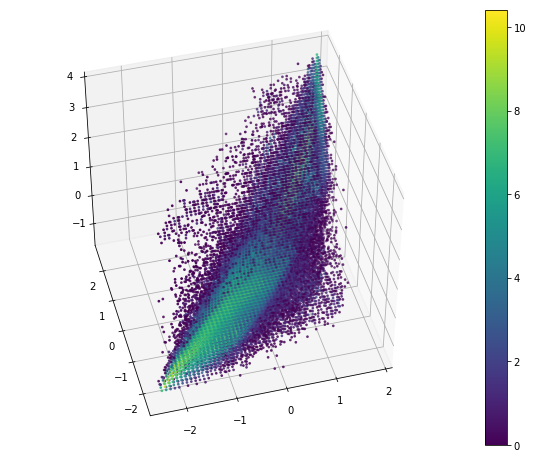

In [7]:
hist3d(dl.getScaledRgbArray(), azim=-105)

# Making clustering happen

### Operate on a subset of the data

Note that the file that we've loaded in was first shuffled — randomly reordering the points. Therefore, the next operation is equivalent to choosing 1 000 000 random points from the data set. Note that this means we're undersampling by a factor of 57; however, there is also much redundancy in the point cloud data due to overlapping (lon,lat) pairs.

In [8]:
# Use 1 000 000 points
data = pd.concat((dl.data[0], dl.data[1]))

### Generate the point features

Collect the (z,r,g,b) tuples of the 10 nearest neighbours; include them and their distance to each point as a row in a feature matrix. 

``10 neighbours * (|(z,r,g,b)| + 1) = 50 features``

Note that 10 was selected semi-arbitrarily — mostly we are looking to use an approximate area of 1 metre to generate features to characterize land type. The rather faulty intuition is that 10 points * 10 cm point resolution approximately characterizes 1 square metre of land.

In [9]:
ptFtrs = generatePointFeatures(data.values)

fitting nearest neighbours...done.
getting k neighbors for each point...done
scaling feature data...done.
fetching point features...done.


### Clustering land types

Run mini batch k means to cluster the land types. I chose 20 clusters arbitrarily. We'll see later on that maybe this is too large a number.

In [10]:
# number of clusters
n_clusters=20
km = miniBatchKMeans(ptFtrs, n_clusters=n_clusters)

`km` returns distances to each "cluster centre". If I find the cluster centre with shortest distance to each point, then that is the cluster that point belongs to. I determine `clusterMembership` in this way. 

In [11]:
clusterMembership = getClusterMembership(km, ptFtrs)

## Plotting the data

First plot the original data. For the sake of my computer, I'm plotting 1 000 000 points. 

In [12]:
# number of points to plot
N = 100000

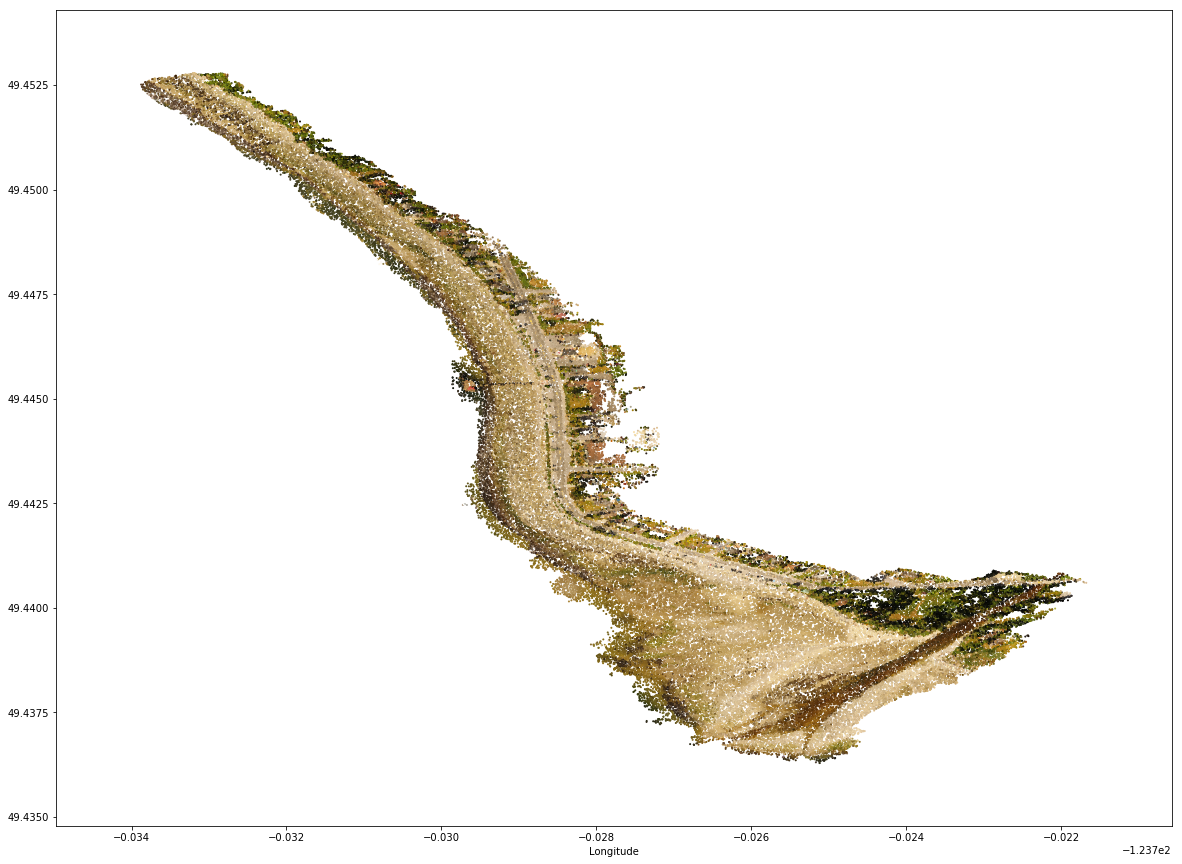

In [13]:
plt.figure(figsize=(20,15))
plt.scatter(x=data.values[:N,0], y=data.values[:N,1], c=data.values[:N, 3:6]/255, s=1, cmap='gist_earth')
plt.xlabel('Longitude');

Next, plot all of the clusters together. Note that the algorithm can differentiate houses and road, and fine details in the delta at the Southeast of the image. 

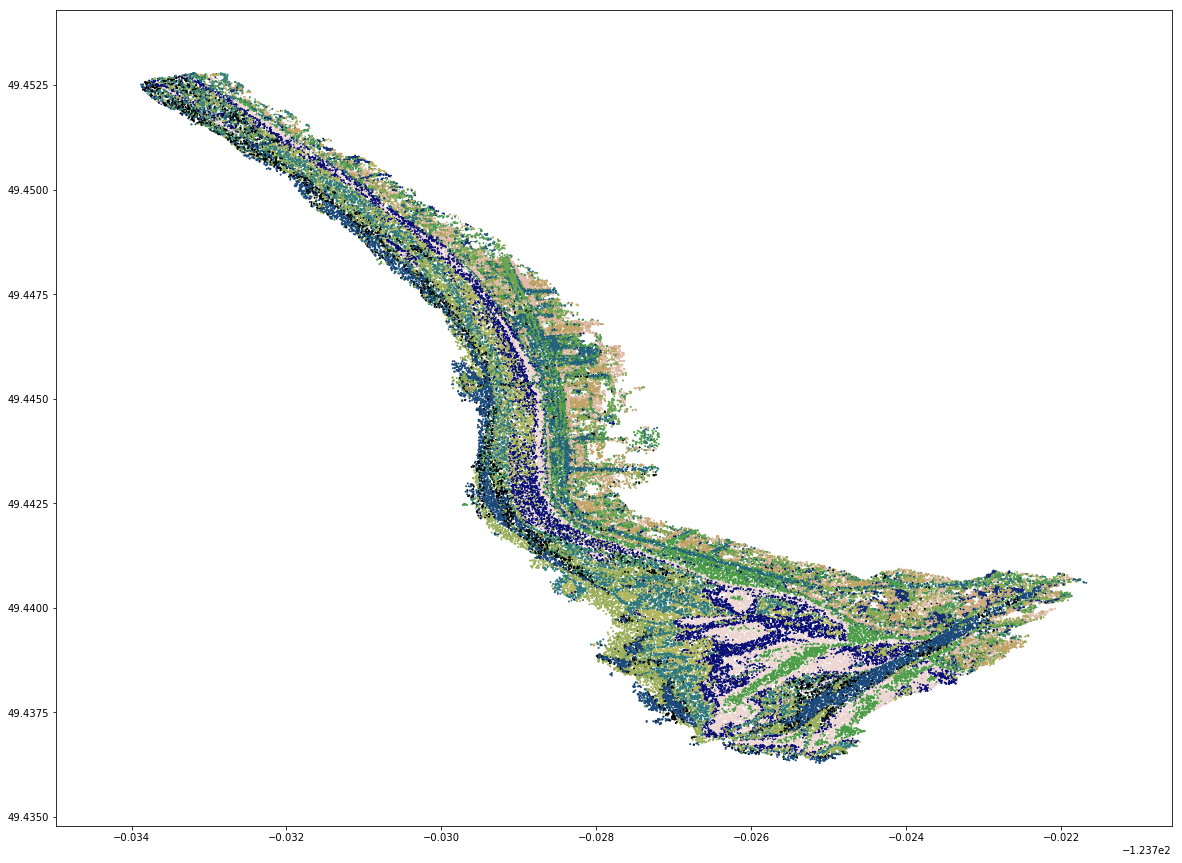

In [14]:
makeScatterPlot(data.values[:N, :2], clusterMembership[:N], nClusters=n_clusters)

## Individual clusters

For slightly more granularity, we plot all of the clusters in their own plots to see how the unsupervised segmentation performed. 

In [15]:
clusterData = {j : data.values[clusterMembership==j, :] for j in range(n_clusters)}

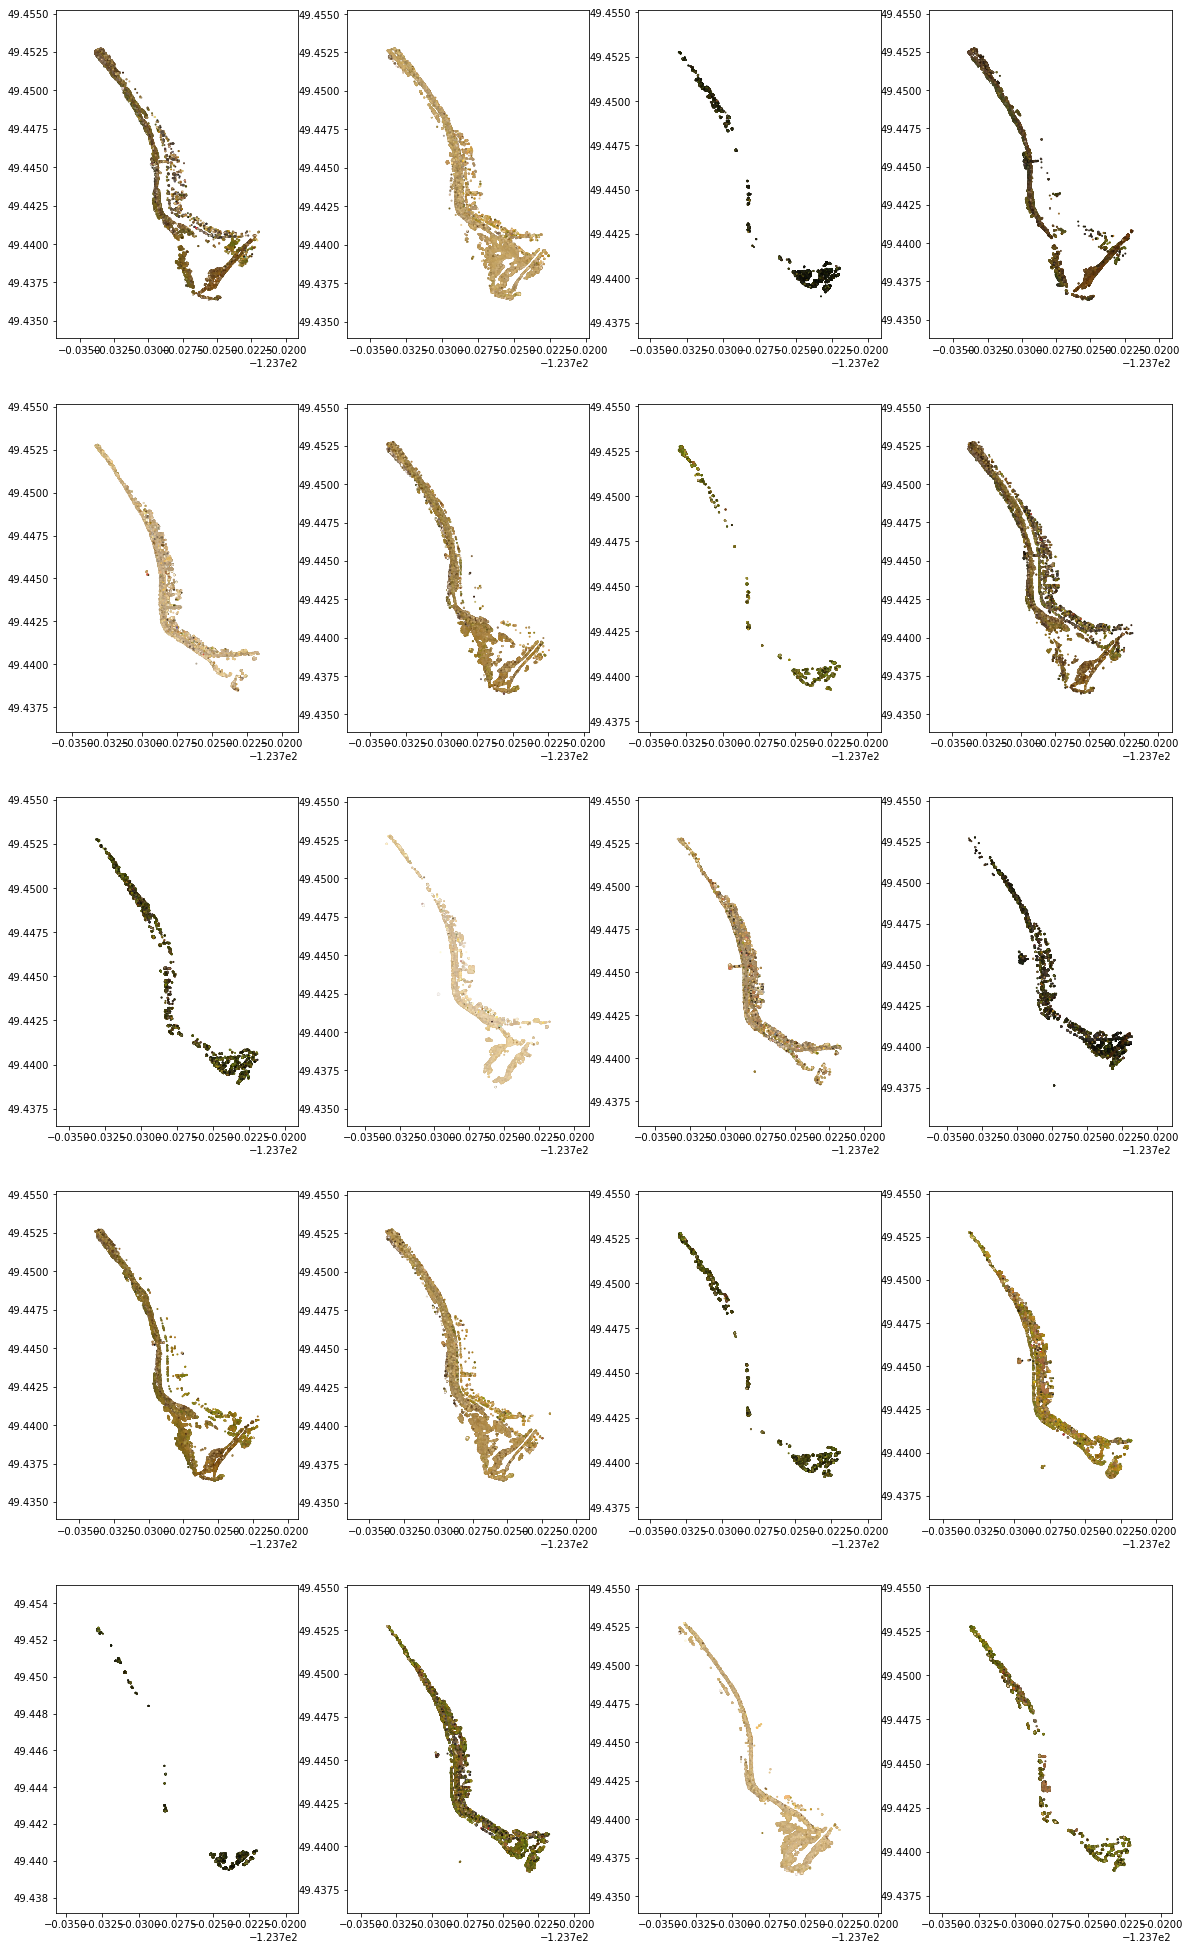

In [16]:
ncols = 4
nrows = n_clusters / 4

plt.figure(figsize=(5*ncols, 7*nrows))


for j in range(n_clusters):
    clusterj = clusterData[j]
    plt.subplot(nrows, ncols, j+1)
    plt.scatter(clusterj[:N,0], clusterj[:N, 1], c=clusterj[:N, 3:6]/255, s=1)

## Color histograms of the users

As per what the project group did, I will include RGB histograms for each cluster; these should give us a vague idea of whether too small a value for k was chosen (too few clusters means the histograms should appear very multimodal), or if too high a value for k was chosen (too many clusters means that several of the histograms should look identical; however, identical histograms is not sufficient to imply too high a value for k). 

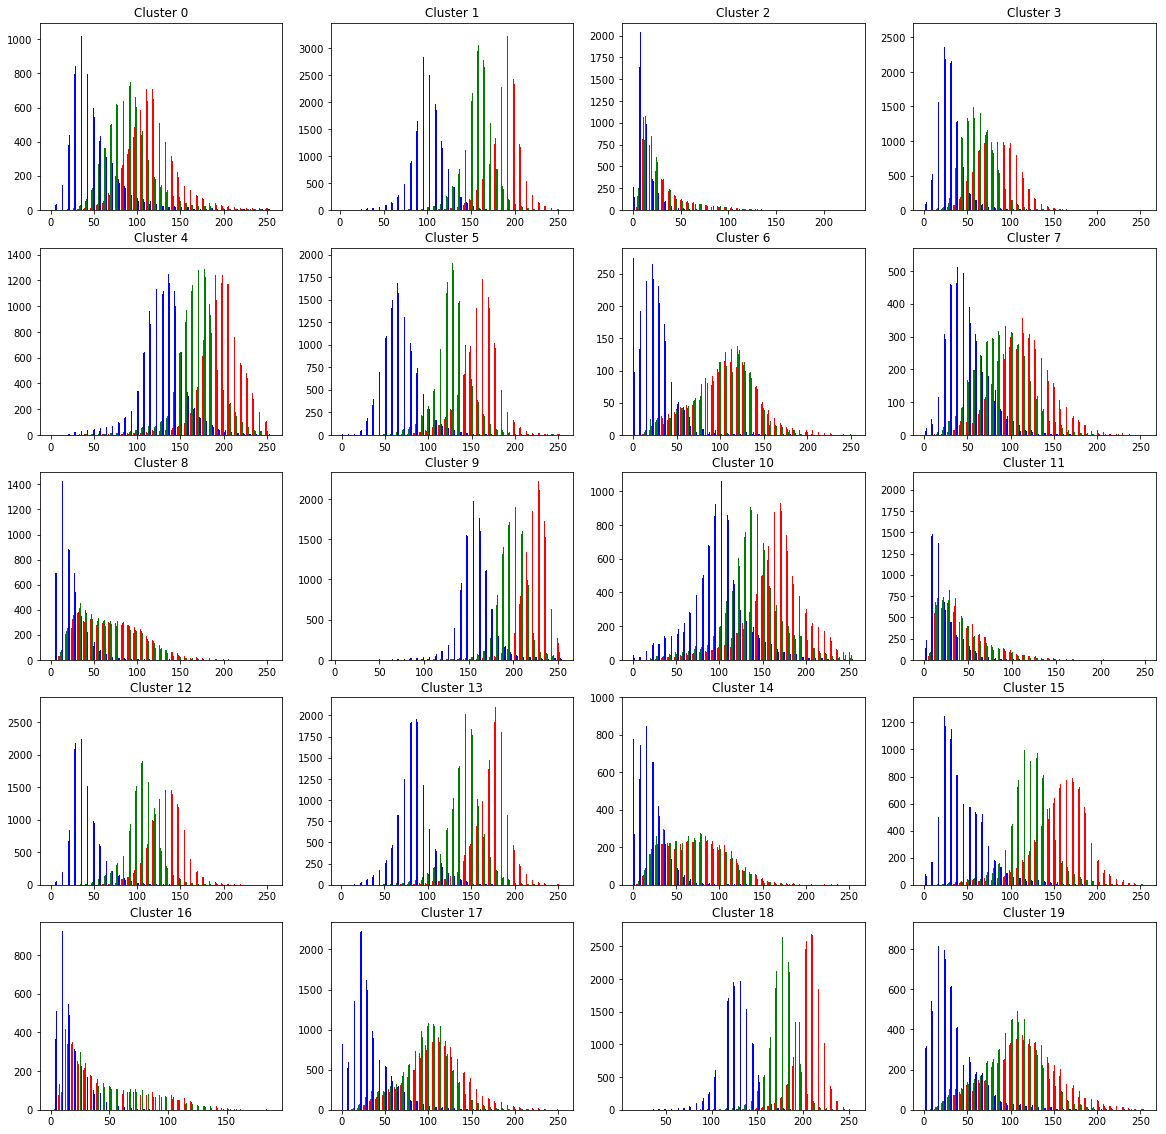

In [17]:
ncols = 4
nrows = n_clusters/ncols

plt.figure(figsize=(5*ncols, 4*nrows))


for j in range(n_clusters):
    clusterj = clusterData[j]
    plt.subplot(nrows, ncols, j+1)
    plt.hist(clusterj[:N, 3:6], bins=256, color=['r', 'g', 'b']);
    plt.title('Cluster {}'.format(j))

Some of these distributions look nearly identical. I believe this suggests that we've chosen too many clusters. Further work might use a Bayesian approach or cross-validation in selecting the "right" number of clusters. Hierarchical clustering methods could also be used. 